# Variational Auto-Encoders

In this notebook, the goal is to generate new images using auto-encoders.
The focus lies mainly on variational auto-encoders
and how they differ from the classic auto-encoders.

In [1]:
import os

import torch
import numpy as np
import torchvision
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision import transforms
from PIL import Image

torch.manual_seed(1806)
torch.cuda.manual_seed(1806)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


print('Python version: 3.9.12')
print('Pytorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
print('numpy version:', np.__version__)

cpu
Python version: 3.9.12
Pytorch version: 1.13.0
torchvision version: 0.14.0
numpy version: 1.21.5


In [13]:
class AutoMNIST(datasets.MNIST):
    """ Wrapper around MNIST for training auto-encoders. """
    
    def __getitem__(self, index):
        x = self.data[index].numpy()
        img = Image.fromarray(x, mode='L')
        target = Image.fromarray(x, mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    @property
    def raw_folder(self):
        return os.path.join(self.root, 'MNIST', 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, 'MNIST', 'processed')
    
    def get_subset_with_label(self, label: int):
        indices = [i for i in range(len(self)) if self.targets[i] == label]
        return Subset(self, indices)


def get_auto_mnist_loader(train: bool = True, flat: bool = False, 
                          raw_targets: bool = False,download = False, **kwargs) -> DataLoader:
    """
    Construct a data loader for training auto-encoders on MNIST.
    
    Parameters
    ----------
    train : bool, optional
        If `True`, use the MNIST training data, 
        otherwise use the test data.
    flat : bool, optional
        If `True`, the images is flattened in pre-processing.
    raw_targets : bool, optional
        If `True`, the target values are not normalised,
        otherwise (the default), they are normalised
        in the same way as the inputs are.
    kwargs
        Additional keyword arguments for data loader.
        E.g. batch_size, shuffle, num_workers, ...

    Returns
    -------
    loader : DataLoader
        A data loader that iterates over the MNIST data,
        where the inputs are properly normalised images
        and the targets are either the raw images with pixels in [0, 1]
        or equivalent to the inputs, depending on `raw_targets`.
    """
    to_tensor = transforms.ToTensor()
    normalise = transforms.Compose([
        to_tensor, transforms.Normalize((.1307, ), (.3081, ))
    ])
    
    if flat:
        flatten = nn.Flatten(start_dim=0)
        to_tensor = transforms.Compose([to_tensor, flatten])
        normalise.transforms.append(flatten)
    
    _transforms = {
        'transform': normalise,
        'target_transform': to_tensor if raw_targets else normalise
    }
    
    data = AutoMNIST("~/.pytorch", train=train, download = download, **_transforms)
    loader = DataLoader(data, **kwargs)
    return loader

In [14]:
def data_to_image(*data: torch.Tensor, 
                  means: tuple = (0, ), stds: tuple = (1., )) -> Image:
    """
    Convert multiple tensors to one big image.
    
    Parameters
    ----------
    data0, data1, ... dataN : torch.Tensor
        One or more tensors to be merged into a single image.
    means : tuple or torch.Tensor, optional
        Original mean of the image before normalisation.
    stds : tuple or torch.Tensor, optional
        Original standard deviation of the image before normalisation.

    Returns
    -------
    image : Image
        PIL image with all of the tensors next to each other.
    """
    # concatenate all data
    big_pic = torch.cat([x for x in data], dim=-1)
    
    means = torch.tensor(means)
    stds = torch.tensor(stds)
    to_image = transforms.Compose([
        # inverts normalisation of image
        transforms.Normalize(-means / stds, 1. / stds),
        transforms.Lambda(lambda x: torch.clamp(x, 0, 1)),
        transforms.ToPILImage()
    ])
    
    return to_image(big_pic)


def display_result(auto_encoder: nn.Module, xs: torch.Tensor, count: int = 10):
    """
    Visualise a number of reconstructions from an auto-encoder.
    
    Parameters
    ----------
    auto_encoder : nn.Module
        The auto-encoder to visualise reconstructions for.
    xs : torch.Tensor
        Batch of images to be reconstructed.
        The batch is assumed to have the correct shape
        for feeding it to the network.
    count : int, optional
        Number of samples in the batch to visualise.

    """
    xs = xs[:count]
    model_dev = next(auto_encoder.parameters()).device
    # get reconstructions
    preds = auto_encoder.reconstruct(xs.to(model_dev)).cpu()
    if preds.min() < 0:
        preds = preds * .3081 + .1307    # unnormalise
    
    # convert to images
    xs = xs.view(-1, 1, 28, 28)  # unflatten
    x_im = data_to_image(*xs, means=(.1307, ), stds=(.3081, ))
    preds = preds.view(-1, 1, 28, 28)
    res_im = data_to_image(*preds)
    
    # paste together
    im = Image.new('L', (len(xs) * 28, 56))
    im.paste(x_im, (0, 0))
    im.paste(res_im, (0, 28))
    display(im, metadata={'width': '100%'})

In [4]:
class RegularisedLoss(nn.Module):
    """
    Loss function for networks that expose state for regularisation.

    Examples
    --------
    To train an auto-encoder with some norm-regularisation (untested):
    >>> ae = AutoEncoder(784)
    >>> mse = RegularisedLoss(nn.MSELoss(), torch.norm)
    >>> x = torch.randn(1, 784)
    >>> logits, code = ae.forward(x)
    >>> mse((logits, code), x)
    """
    
    def __init__(self, loss_func: nn.Module = None, reg_func: nn.Module = None,
                 weight: float = 1.):
        """
        Parameters
        ----------
        loss_func : nn.Module
            Standard loss function computed from logits and targets.
        reg_func : nn.Module, optional
            Regularisation function computed from exposed network state.
        weight : float, optional
            Weighting factor for the regularisation.
        """
        super().__init__()
        self.loss_func = loss_func
        self.regulariser = reg_func
        self.weight = weight
        self._regularisation_cache = []
        
    def split_loss(self, total_loss):
        """
        Split total loss values in original loss and regularisation part.

        Parameters
        ----------
        total_loss : list or float
            One or more loss values computed with this function.

        Returns
        -------
        orig_loss : Tensor
            One ore more loss values from the original part of the loss.
        reg_loss : Tensor
            One or more loss values from the regularsiation part of the loss.
        """
        if len(self._regularisation_cache) == 0:
            raise ValueError("no regularisation loss founc, make sure to call forward first")
            
        _totals = torch.tensor(total_loss)
        reg_loss = torch.tensor(self._regularisation_cache[-_totals.numel():])
        orig_loss = _totals - reg_loss
        return orig_loss, reg_loss
        
    def forward(self, outputs, y):
        """
        Parameters
        ----------
        outputs : (Tensor, Tensor)
            Tuple consisting of logits and exposed state.
        y : Tensor
            Targets for the original loss part.
        """
        logits, state = outputs
        loss = self.loss_func(logits, y)
        
        if self.regulariser is not None:
            reg_loss = self.weight * self.regulariser(state)
            self._regularisation_cache.append(reg_loss.item())
            loss = loss + reg_loss
        
        return loss

In [5]:
def _forward(network: nn.Module, data: DataLoader, metric: callable):
    device = next(network.parameters()).device
    
    for x, y in data:
        x, y = x.to(device), y.to(device)
        outputs = network(x)
        res = metric(outputs, y)
        yield res

@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> list:
    network.eval()

    results = _forward(network, data, metric)
    return [res.item() for res in results]


@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module,
           opt: optim.Optimizer, regulariser: nn.Module = None) -> list:
    network.train()

    errs = []
    for err in _forward(network, data, loss):
        errs.append(err.item())

        opt.zero_grad()
        err.backward()
        opt.step()

    return errs

In [6]:
def print_errs(epoch: int, errs : list, objective: nn.Module):
    """
    Print error summary for current epoch.

    If possible, the loss is additionally decomposed in
    reconstruction and regularisation loss.

    Parameters
    ----------
    epoch : int
        Rank of the current epoch.
    errs : list
        The errors to summarise.
    objective : nn.Module
        The loss function that was used to compute the errors.
        In case of a `RegularisedLoss`, this will be used to split
        into reconstruction and regularisation parts of the loss.
    """
    print(f"Epoch {epoch: 2d} - avg loss: {sum(errs) / len(errs):.6f}", end=' ')
    try:
        rec_errs, reg_errs = objective.split_loss(errs)
        print(f"(rec: {sum(rec_errs) / len(errs):.4f}, reg: {sum(reg_errs) / len(errs):.4f})")
    except (AttributeError, ValueError):
        print()

        
def log_results(epoch: int, ae : nn.Module, vis_every: int):
    """
    Sporadically visualise results.

    Parameters
    ----------
    epoch : int
        Rank of the current epoch.
    ae : nn.Module
        The auto_encoder to log distributions for.
    vis_every : int
        Frequency of visualising the reconstructions
        and logging embeddings to tensorboard.
    """
    dev = next(ae.parameters()).device
    with torch.no_grad():
        ref_inputs = torch.stack([loader.dataset[i][0] for i in range(64)])
        z = ae.encode(ref_inputs.to(dev))

    if epoch % vis_every == 0:
        display_result(ae, ref_inputs)
        ref_labels = [str(label.item()) for label in loader.dataset.targets[:64]]
        ref_images = 1. - loader.dataset.data[:64].unsqueeze(1)


def train_auto_encoder(auto_encoder: nn.Module, loader: DataLoader,
                       objective: nn.Module, optimiser: optim.Optimizer,
                       num_epochs: int = 10, vis_every: int = 5):
    """
    Train an auto-encoder for a number of epochs.

    Parameters
    ----------
    auto_encoder : nn.Module
        The auto-encoder to train
    loader : DataLoader
        A data loader for iterating over batches of the data.
    objective : nn.Module
        The loss function to optimise during training.
    optimiser : optim.Optimizer
        The optimiser to use for training.
    num_epochs : int, optional
        Number of times to iterate the dataset.
    vis_every : int, optional
        Frequency, during training, of
        intermediate visualisation of reconstructions.
    """
    # evaluate random performance
    errs = evaluate(auto_encoder, loader, objective)
    print_errs(0, errs, objective)
    log_results(0, auto_encoder, vis_every)

    # train for some epochs
    for i in range(1, num_epochs + 1):
        errs = update(auto_encoder, loader, objective, optimiser)
        print_errs(i, errs, objective)
        log_results(i, auto_encoder, vis_every)

## Variational Auto-Encoders

Variational auto-encoders (VAEs) extend auto-encoders in a probabilistic way.
Although this might sound complicated, it only requires a few modifications to make an auto-encoder variational.
First of all, the latent space is regularised to stay close to a (standard normal) distribution.
Secondly, VAEs do not produce specific codes, but rather a distribution of codes.
In practice this is done by directly mapping inputs to the parameters of a distribution.

The main advantage of this approach, is that the the distribution of the latent codes remains well under control.
As a result, we can sample from this latent distribution and decode these sampled codes to generate new data.

### Task 1: VAE Architecture

VAEs predict the distribution parameters of the latent space,
rather than a specific code in the latent space.
In the case of a Gaussian latent distribution, 
this means that the encoder produces a mean and log-variance for every input sample.
By predicting the log-variance, the variance is guaranteed to be positive.

Because the codes of a VAE are distributions, it is not possible to directly decode them back to images.
Instead, specific codes have to be sampled from the latent distribution before decoding.
This is the only real difference, architecturally, between AEs and VAEs.

 > Implement the `VariationalAutoEncoder` class.
 > The `sample` method should sample a latent vector from a Gaussian with given mean and log-variance. 
 > Note that the `sample` function for a VAE must be differentiable!
 > The `generate` method should allow to create one or more new images, given a mean in the latent space.

In [7]:
class VariationalAutoEncoder(nn.Module):
    """ Fully connected auto-encoder. """

    def __init__(self, in_features: int, code_features: int = 20, 
                 hidden_features: int = 400):
        super().__init__()
        self.in_features = in_features
        self.code_features = code_features
        
        self.encoder_1 = torch.nn.Linear(in_features,hidden_features)
        self.encoder_mean = torch.nn.Linear(hidden_features,code_features)
        self.encoder_var = torch.nn.Linear(hidden_features,code_features)
        
        self.decoder_1 = torch.nn.Linear(code_features,hidden_features)
        self.decoder_2 = torch.nn.Linear(hidden_features,in_features)

        
    def sample(self, mean: torch.Tensor, log_var: torch.Tensor):
        """
        Sample randomly from the latent space in a differentiable manner.

        Parameters
        ----------
        mean : (N, code_featuers) Tensor
            Mean(s) for sampling new images.
        log_var : (N, code_features) Tensor
            Logarithm of variance(s) for sampling new images.

        Returns
        -------
        sample : (N, code_features) Tensor
            The randomly generated sample in latent space.
        """
        norm_distr = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(self.code_features), torch.eye(self.code_features))
        eps = norm_distr.sample()
        std_norm = torch.exp(0.5 * log_var)
        
        z = mean + std_norm * eps
        return z
        
        
    def forward(self, x):
        #Encoder
        x = self.encoder_1(x)
        x = nn.ReLU()(x)
        x_mean = self.encoder_mean(x)
        x_logvar = self.encoder_var(x)
        
        #Latent distribution
        z = self.sample(x_mean,x_logvar)
        
        #Decoder
        x = self.decoder_1(z)
        x = nn.ReLU()(x)
        x = self.decoder_2(x)
        return x,(x_mean,x_logvar)
        
        
    
    @torch.no_grad()
    def generate(self, mean: torch.Tensor, log_var: torch.Tensor = 0.,
                 batch_size: int = 1) -> torch.Tensor:
        """
        Generate one or more new images.

        Parameters
        ----------
        mean : (N, code_features) Tensor
            Mean in latent space for generating images.
        log_var : (N, code_features) Tensor, optional
            Logarithm of variance(s) in latent space for generating images.
            
        Returns
        -------
        img : (N, in_features) Tensor
            Proper image with the same dimensions as the inputs.

        See Also
        --------
        `sample(mean, log_var)` : sample randomly in latent space.
        """
        #latent vector z
        log_var = torch.as_tensor(log_var)
        z = self.sample(mean,log_var)
        
        #decoder
        x = self.decoder_1(z)
        x = nn.ReLU()(x)
        x = self.decoder_2(x)
        return x
        

    @torch.no_grad()
    def reconstruct(self, x: torch.Tensor) -> torch.Tensor:
        """ Properly reconstruct some inputs. """
        x = self.encoder_1(x)
        x = nn.ReLU()(x)
        mean = self.encoder_mean(x)
        log_var = self.encoder_var(x)
        
        
        return self.generate(mean, log_var)
    
    
    @torch.no_grad()
    def encode(self,x:torch.tensor) -> torch.Tensor:
        x = self.encoder_1(x)
        x = nn.ReLU()(x)
        x_mean = self.encoder_mean(x)
        x_logvar = self.encoder_var(x)
        
        return x_mean,x_logvar
        

### Task 2: VAE Regulariser 

The other main difference with auto-encoders is the regularisation
to keep the latent space close to a standard normal distribution.

 > Analytically compute the Kullback-Leibler divergence
 > between a non-standard Gaussian distribution, $\mathcal{N}(\mu, \sigma^2)$,
 > and the standard normal distribution, $Z = \mathcal{N}(0, 1)$.
 > Implement your result in the `gauss_vae_regulariser` function.
 > Finally, use the `RegularisedLoss` to train the variational auto-encoder 
 > with the regulariser on top of the reconstruction loss. 

$$\begin{aligned}
  D_\mathrm{KL}\big(\mathcal{N}(\mu, \sigma^2) \mathbin{||} Z = \mathcal{N}(0, 1)\big)
\end{aligned}$$

probabilty density function of multivariate Normal distribution:

$$p(\mathbf{x}) = \frac{1}{(2\pi)^{k/2}|\Sigma|^{1/2}} \exp\left(-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\Sigma^{-1}(\mathbf{x}-\boldsymbol{\mu})\right)$$

Now, let our two Normal distributions be $\mathcal{N}(\boldsymbol{\mu_p},\,\Sigma_p)$ and $\mathcal{N}(\boldsymbol{\mu_q},\,\Sigma_q)$

\begin{aligned}
D_{KL}(p||q) & = \mathbb{E}_p\left[\log(p) - \log(q)\right]
\newline
& = \mathbb{E}_p\left[\frac{1}{2}\log\frac{|\Sigma_q|}{|\Sigma_p|} - \frac{1}{2}(\mathbf{x}-\boldsymbol{\mu_p})^T\Sigma_p^{-1}(\mathbf{x}-\boldsymbol{\mu_p}) + \frac{1}{2}(\mathbf{x}-\boldsymbol{\mu_q})^T\Sigma_q^{-1}(\mathbf{x}-\boldsymbol{\mu_q})\right]
\newline
& = \frac{1}{2}\mathbb{E}_p\left[\log\frac{|\Sigma_q|}{|\Sigma_p|}\right] - \frac{1}{2}\mathbb{E}_p\left[(\mathbf{x}-\boldsymbol{\mu_p})^T\Sigma_p^{-1}(\mathbf{x}-\boldsymbol{\mu_p})\right] + \frac{1}{2}\mathbb{E}_p\left[(\mathbf{x}-\boldsymbol{\mu_q})^T\Sigma_q^{-1}(\mathbf{x}-\boldsymbol{\mu_q})\right]
\newline
& = \frac{1}{2}\log\frac{|\Sigma_q|}{|\Sigma_p|} - \frac{1}{2}\mathbb{E}_p\left[(\mathbf{x}-\boldsymbol{\mu_p})^T\Sigma_p^{-1}(\mathbf{x}-\boldsymbol{\mu_p})\right] + \frac{1}{2}\mathbb{E}_p\left[(\mathbf{x}-\boldsymbol{\mu_q})^T\Sigma_q^{-1}(\mathbf{x}-\boldsymbol{\mu_q})\right] 
\end{aligned}


**second term:** can be written as $tr\left\{(\mathbf{x}-\boldsymbol{\mu_p})^T\Sigma_p^{-1}(\mathbf{x}-\boldsymbol{\mu_p})\right\}$, where $tr$ is a trace. Using trace property it can be rewritten as $tr\left\{(\mathbf{x}-\boldsymbol{\mu_p})(\mathbf{x}-\boldsymbol{\mu_p})^T\Sigma_p^{-1}\right\}$


**second term:** $ \frac{1}{2}\mathbb{E}_p\left[tr\left\{(\mathbf{x}-\boldsymbol{\mu_p})(\mathbf{x}-\boldsymbol{\mu_p})^T\Sigma_p^{-1}\right\}\right] = \frac{1}{2}tr\left\{\mathbb{E}_p\left[(\mathbf{x}-\boldsymbol{\mu_p})(\mathbf{x}-\boldsymbol{\mu_p})^T\Sigma_p^{-1}\right]\right\} = \frac{1}{2}tr\left\{\mathbb{E}_p\left[(\mathbf{x}-\boldsymbol{\mu_p})(\mathbf{x}-\boldsymbol{\mu_p})^T\right]\Sigma_p^{-1}\right\}$

using definition of covariance we get:

\begin{aligned}
& = \frac{1}{2}tr\left\{\Sigma_p\Sigma_p^{-1}\right\}
\newline
& = \frac{1}{2}tr\left\{I_k\right\}
\newline
& = \frac{k}{2}
\end{aligned}

**third term:** $\mathbb{E}_p\left[(\mathbf{x}-\boldsymbol{\mu_q})^T\Sigma_q^{-1}(\mathbf{x}-\boldsymbol{\mu_q})\right] = (\boldsymbol{\mu_p}-\boldsymbol{\mu_q})^T\Sigma_q^{-1}(\boldsymbol{\mu_p}-\boldsymbol{\mu_q}) + tr\left\{\Sigma_q^{-1}\Sigma_p\right\}$


**all together:** $D_{KL}(p||q) = \frac{1}{2}\left[\log\frac{|\Sigma_q|}{|\Sigma_p|} - k + (\boldsymbol{\mu_p}-\boldsymbol{\mu_q})^T\Sigma_q^{-1}(\boldsymbol{\mu_p}-\boldsymbol{\mu_q}) + tr\left\{\Sigma_q^{-1}\Sigma_p\right\}\right]$


**If $q$ is $\mathcal{N}(0,\,I)$ then:**

$D_{KL}(p||q) = \frac{1}{2}\left[\boldsymbol{\mu_p}^T\boldsymbol{\mu_p} + tr\left\{\Sigma_p\right\} - k - \log|\Sigma_p|\right]$


In [8]:
def gauss_vae_regulariser(parameters):
    """
    Compute the regularisation factor for training a VAE
    with a Gaussian latent space.

    Parameters
    ----------
    parameters : (Tensor, Tensor)
        Mean and log_var predictions from variational encoder.

    Returns
    -------
    kl_div : Tensor
        The Kullback-Leibler divergence between a Gaussian distribution
        with the given parameters and the standard normal distribution.
    """
    mean_pred = parameters[0]
    log_var_pred = parameters[1]
    D_KL = - 0.5 * torch.sum((1 + log_var_pred - torch.exp(log_var_pred) - torch.square(mean_pred)))
    return D_KL


Epoch  0 - avg loss: 0.698485 (rec: 0.6982, reg: 0.0003)


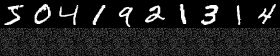

Epoch  1 - avg loss: 0.143045 (rec: 0.1289, reg: 0.0141)
Epoch  2 - avg loss: 0.116881 (rec: 0.1030, reg: 0.0139)


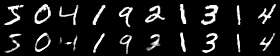

Epoch  3 - avg loss: 0.113071 (rec: 0.0993, reg: 0.0138)
Epoch  4 - avg loss: 0.111086 (rec: 0.0973, reg: 0.0137)


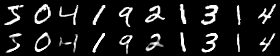

In [20]:
loader = get_auto_mnist_loader(flat=True, raw_targets=True, batch_size=32, shuffle=True, num_workers=0,download = True)
var_ae = VariationalAutoEncoder(784).to(device)
adam = optim.Adam(var_ae.parameters())
bce = RegularisedLoss(nn.BCEWithLogitsLoss(), gauss_vae_regulariser, weight= 1e-5)#nn.BCEWithLogitsLoss()  nn.MSELoss()
train_auto_encoder(var_ae, loader, bce, adam,num_epochs = 4, vis_every = 2)

In [21]:
# sanity check: generating new images
var_ae.cpu()
five_orig = 1 - loader.dataset.data[0].float().unsqueeze(0)
five_mean, five_log_var = var_ae.encode(loader.dataset[0][0])
five_recon = 1 - var_ae.generate(five_mean, five_log_var).view(1, 28, 28)
five_new = var_ae.generate(five_mean.expand(5, -1), five_log_var.expand(5, -1)).view(-1, 1, 28, 28)

im = data_to_image(five_orig, five_recon, *five_new)
display(im, metadata={'width': '100%'})

rand_new = var_ae.generate(torch.randn(7, var_ae.code_features)).view(-1, 1, 28, 28)
im = data_to_image(*rand_new)
display(im, metadata={'width': '100%'})

### Task 3: Control of Generation

One of the main virtues of VAEs is that they can be very effective
in manipulating existing images to create variations of these images.
E.g. non-trivial interpolation or transformations of images
can easily be done by doing some arithmetic in the latent space.

 > Use a VAE to implement the generative functions below.
 > The `interpolate` function should be able to generate images
 > that are *visually between* two given images.
 > The `transform` function takes two reference images
 > that *describe* some sort of transformation
 > together with an image that should be transformed in the same way.

In [22]:
def interpolate(vae: nn.Module, start_x: torch.Tensor, stop_x: torch.Tensor, 
                count: int = 1) -> torch.Tensor:
    """
    Generate interpolating images with a VAE.

    Parameters
    ----------
    vae : nn.Module
        The variational auto-encoder.
        The module should have an `encode` and `generate` function.
    start_x : (1, in_shape) torch.Tensor
        The image to start interpolation from.
    stop_x : (1, in_shape) torch.Tensor
        The image to stop interpolation at.
    count : int, optional
        The number of images to generate between the original images.

    Returns
    -------
    interpolated : (`count + 2`, out_shape) torch.Tensor
        The interpolated images together with the original reconstructions.
    """
    images = [start_x]
    
    alphas = np.linspace(0,1,count + 2)
    alphas = alphas[1:len(alphas) - 1]
    
    start_mean,start_var = vae.encode(start_x)
    stop_mean,stop_var = vae.encode(stop_x)
    
    new_means = []
    new_vars = []
    for a in alphas:
        new_means.append(start_mean * (1-a) + stop_mean * a)
        new_vars.append(start_var * (1-a) + stop_var * a)
        
        
    for i in range(count):
        images.append(vae.generate(new_means[i],new_vars[i]))
        
    images.append(stop_x)
    return torch.cat(images,axis = -1)
        
        
    

In [23]:
# sanity check
thin_zero, wide_zero = 68, 56  # MNIST indices
start, _ = loader.dataset[thin_zero]
stop, _ = loader.dataset[wide_zero]

interpolations = interpolate(var_ae, start.unsqueeze(0), stop.unsqueeze(0), count=3)
images = interpolations.view(-1, 1, 28, 28)
display(data_to_image(*images), metadata={'width': '100%'})

In [24]:
def transform(vae: nn.Module, start_ref: torch.Tensor, stop_ref: torch.Tensor,
              x: torch.Tensor) -> torch.Tensor:
    """
    Transform an image based on the transformation between two other images.

    Parameters
    ----------
    vae : nn.Module
        The variational auto-encoder.
        The module should have an `encode` and `generate` function.
    start_ref : (1, in_shape) torch.Tensor
        The reference image before the transformation.
    stop_ref : (1, in_shape) torch.Tensor
        The reference image after the transformation.
    x : (N, in_shape) torch.Tensor
        The image(s) to transform in the same way as the reference.

    Returns
    -------
    transformed : (N, out_shape) torch.Tensor
        The images in `x` transformed according to the reference.
    """
    start_mean,start_var = vae.encode(start_ref)
    stop_mean,stop_var = vae.encode(stop_ref)
    
    diff_mean,diff_var = (stop_mean - start_mean),(stop_var - start_var)
    
    mean,var = vae.encode(x)
    mean += diff_mean
    var += diff_var
    
    x_img = vae.generate(mean,var)
    
    return x_img
    

In [25]:
# sanity check
thin_indices = 1, 14, 76, 44, 2, 35, 18, 84, 144, 22
digits = torch.stack([loader.dataset[i][0] for i in thin_indices])
ref_im = data_to_image(*digits.view(-1, 1, 28, 28), means=(.1307, ), stds=(.3081, ))
display(ref_im, metadata={'width': '100%'})

start_ref, _ = loader.dataset[thin_zero]
stop_ref, _ = loader.dataset[wide_zero]

transformed = transform(var_ae, start_ref.unsqueeze(0), stop_ref.unsqueeze(0), digits)
images = transformed.view(-1, 1, 28, 28)
display(data_to_image(*images), metadata={'width': '100%'})